In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

import copy
import math
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from scipy.ndimage import label, center_of_mass
from skimage.measure import regionprops
from scipy.ndimage import zoom
from scipy.optimize import minimize
from sklearn.linear_model import RANSACRegressor



DATA_COLLECTION = "/mnt/labnas/DataCollection"
base_dir = os.path.join(DATA_COLLECTION, "Project", "RadiSmart", "cardiac", "healthy")
demo_dir = os.path.join(base_dir, "000652515")

img meta: 
 shape:(17, 64, 64) 
 spacing:(6.6437, 6.643699, 6.643699)
img meta: 
 shape:(136, 64, 64) 
 spacing:(6.6437, 6.643699, 6.643699)
img meta: 
 shape:(9, 20, 340) 
 spacing:(6.6437, 6.643699, 6.643699)


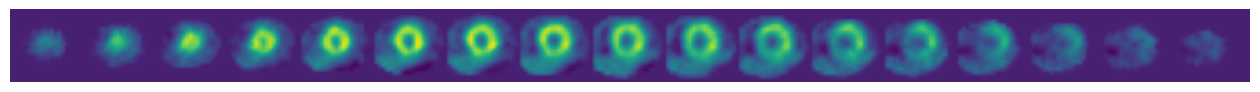

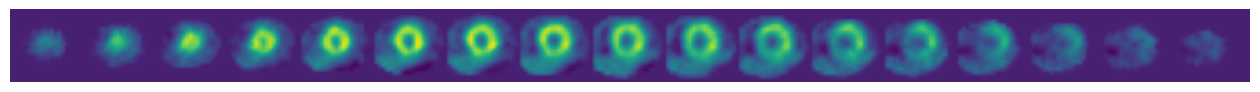

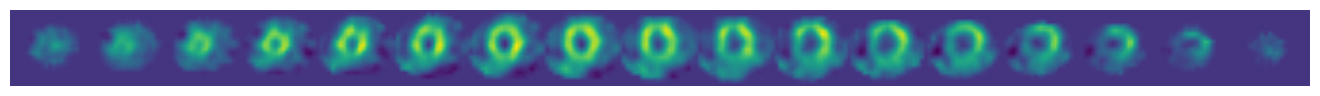

In [2]:
def read_sitk_img(path):
    sitk_img = sitk.ReadImage(path)
    img_arr = sitk.GetArrayFromImage(sitk_img)
    # SimpleITK: image[x,y,z]; numpy: image_numpy_array[z,y,x]
    print(f"img meta: \n shape:{img_arr.shape} \n spacing:{sitk_img.GetSpacing()[::-1]}")
    return img_arr


non_gate_img3d = read_sitk_img(os.path.join(demo_dir, "154"))
gate_img4d = read_sitk_img(os.path.join(demo_dir, "155"))
view_results3d = read_sitk_img(os.path.join(demo_dir, "161"))



plt.figure(figsize=(16, 5))
plt.imshow(view_results3d[0], interpolation="bilinear")
plt.axis('off')
plt.show()


width = 20
# 计算中心位置
center = np.array(non_gate_img3d.shape)//2
start = center - width//2
end = center + width//2

clipped_non_gate_img3d = non_gate_img3d[:, start[1]:end[1], start[2]:end[2]].copy()
plt.figure(figsize=(16, 5))
plt.imshow(clipped_non_gate_img3d.transpose(1, 0, 2).reshape(width, -1), interpolation="bilinear")
plt.axis('off')
plt.show()


clipped_gate_img4d = gate_img4d[:, start[1]:end[1], start[2]:end[2]].copy()
unit = clipped_gate_img4d.shape[0] // 8

plt.rcParams["animation.html"] = "jshtml"
fig = plt.figure(figsize=(13, 1))
plt.ioff()
def animate(t):
    plt.cla()
    # plt.plot(x-t,x)
    frame_i = clipped_gate_img4d[t*unit: (t+1)*unit]
    plt.imshow(frame_i.transpose(1, 0, 2).reshape(width, -1), interpolation="bilinear")
    plt.axis('off')  # Hide axes and ticks completely
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove padding

# Create animation
FuncAnimation(fig, animate, frames=8)

In [3]:
def cal_lv_mask3d(img3d, meta, preframe_info=None, debug=False):
    pass

限制条件:  min_volume(mm^3):40000, min_distance(mm):100
当前连通域:  volume:69442.2658995146, distance:23.98620505524861
Success


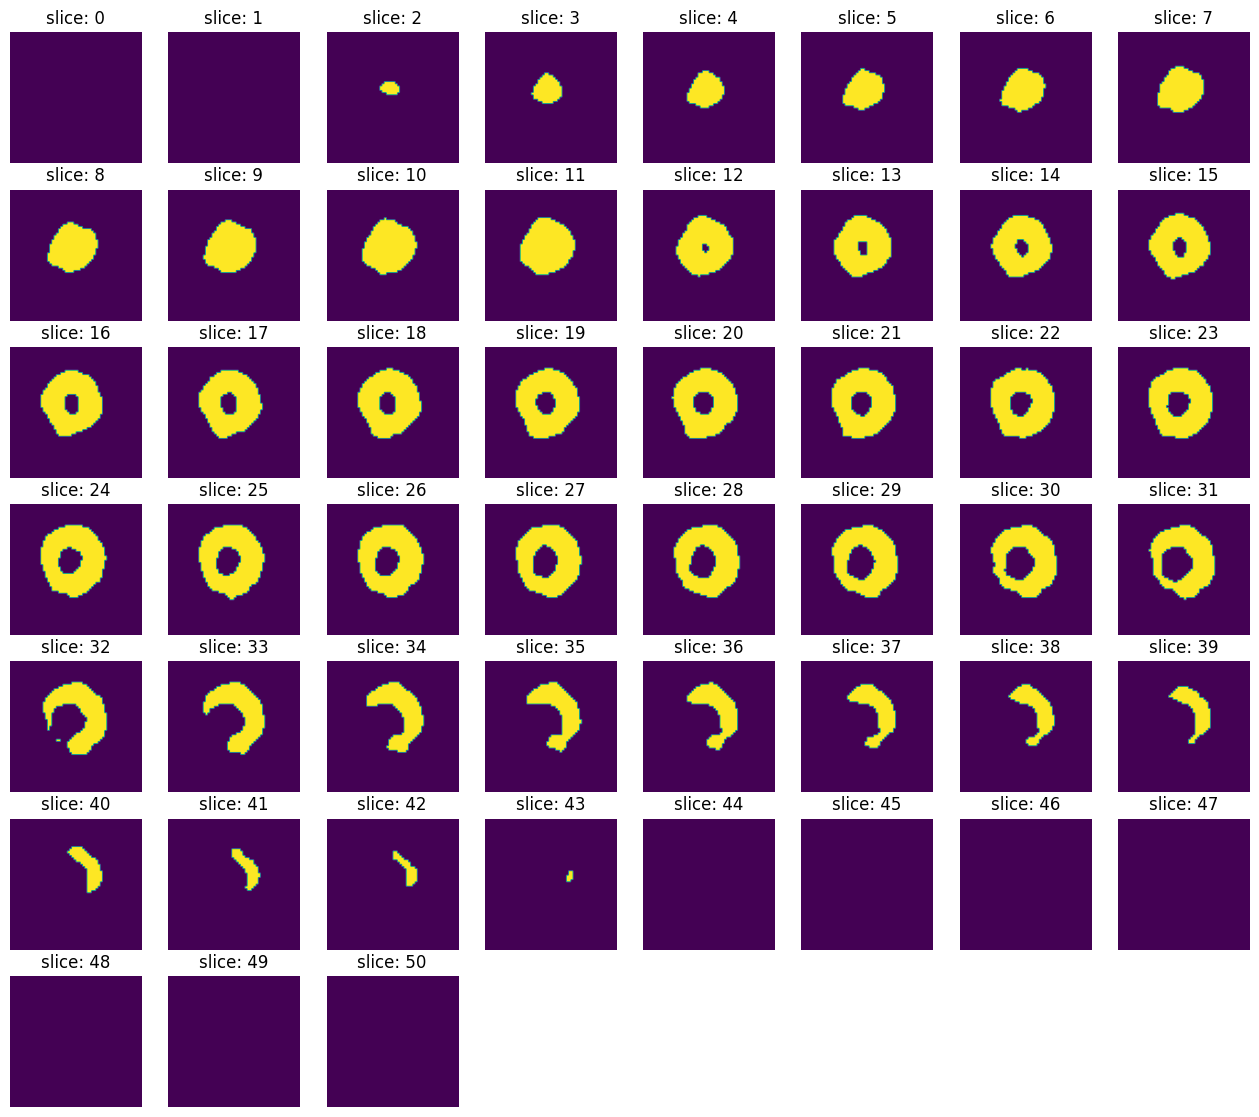

In [3]:
zoom_factor = 3
zoomed_clipped_non_gate_img3d = zoom(clipped_non_gate_img3d, zoom_factor, cval=0)
pixel_size = np.array((6.6437, 6.643699, 6.643699))/zoom_factor

# step 1: segment mask by threshold and volume
def naive_segment_lv_mask(img3d, pixel_size, min_volume_in_mm3=40000, min_distance_in_mm=100):
    
    _img3d = img3d.copy()
    _pixel_size = np.array(pixel_size).copy()
    
    max_intensity = np.max(_img3d)
    threshold = 0.5 * max_intensity
    
    naive_lv_mask = np.zeros_like(img3d, dtype=np.uint8)
    while threshold <= max_intensity:
        binary_image = _img3d > threshold
        labeled_image, num_features = label(binary_image)
        
        center = np.array(img3d.shape) / 2
        for region in regionprops(labeled_image):
            centroid = np.array(region.centroid)
            # 乘以了 pixel size 才是长度 单位: mm
            distance = np.linalg.norm(centroid - center) * np.linalg.norm(_pixel_size)
            region_vloume = region.area * np.linalg.norm(_pixel_size)
            
            # 检查区域是否对称且体积大于最小阈值
            if distance < min_distance_in_mm and region_vloume >= min_volume_in_mm3:
                naive_lv_mask[labeled_image == region.label]=1
                print(f"限制条件:  min_volume(mm^3):{min_volume_in_mm3}, min_distance(mm):{min_distance_in_mm}")
                print(f"当前连通域:  volume:{region_vloume}, distance:{distance}")
                
        if np.sum(naive_lv_mask):
            print('Success')
            break
        # 减小阈值
        threshold += 0.05 * max_intensity
        print('Fail...')
    
    return naive_lv_mask

naive_lv_mask = naive_segment_lv_mask(zoomed_clipped_non_gate_img3d, pixel_size)

plt.figure(figsize=(16, 16))
for i in range(min(naive_lv_mask.shape[0], 64)):
    ax = plt.subplot(8,8,i+1)
    plt.imshow(naive_lv_mask[i])
    ax.set_title(f"slice: {i}")
    ax.set_axis_off()
plt.show()

(60, 60) 24909


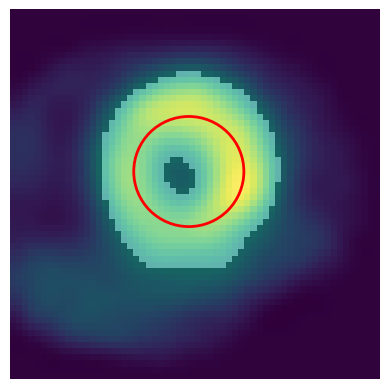

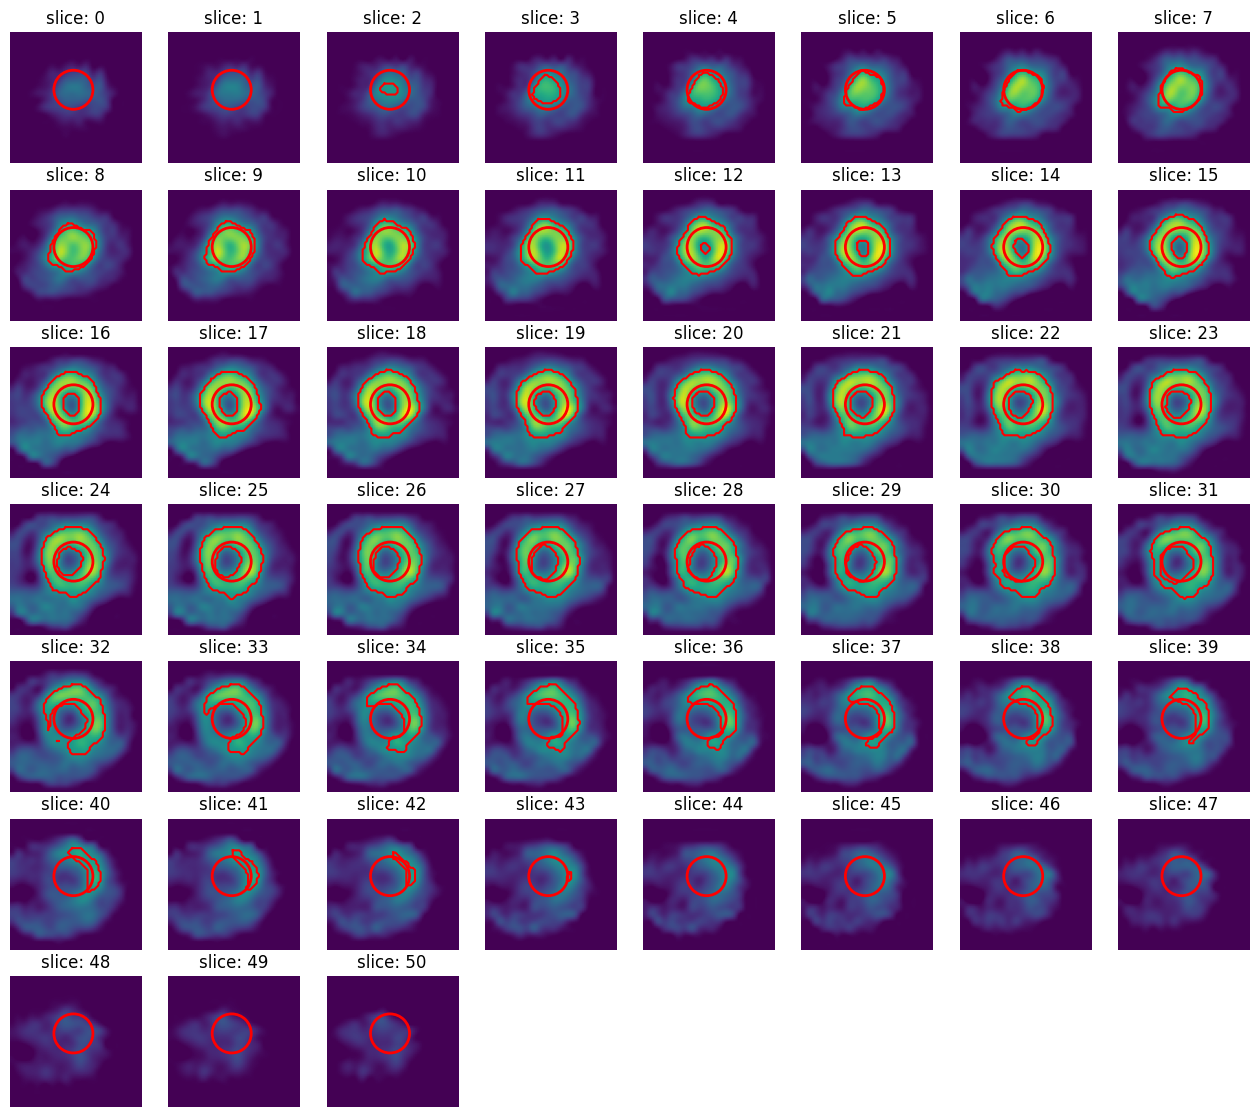

In [4]:
# step 2: locate center: cy, cx; radius: r
def naive_cal_circle_param(img3d, lv_mask=None, factor=0.8):
    z_len, y_len, x_len = img3d.shape
    if lv_mask is None:
        print(f"lv_mask is None")
        slice_len = int(z_len*factor)
        s_start = (z_len - slice_len)//2
        s_end = z_len-s_start
    else:
        zs,_,_ = np.where(lv_mask==1)
        s_start = np.min(zs)
        s_end = np.max(zs)
    
    sliced_img3d = img3d[s_start:s_end].copy()
    summed_img2d = np.sum(sliced_img3d, axis=0)
    max_intensity = np.max(summed_img2d)
    intensity_mask = summed_img2d > (0.5 * max_intensity)
    
    Y, X = np.ogrid[:y_len, :x_len]
    # 计算质心作为圆心
    cy, cx = center_of_mass(intensity_mask)
    
    distance2center = np.sqrt((X - cy) ** 2 + (X - cx) ** 2)
    cost_func = lambda params: np.sum(summed_img2d*intensity_mask * (np.abs(distance2center - params[0])))
    
    # 初始猜测：图像中心作为圆心，半径初始值为图像尺寸的 1/3 ~ 10
    result = minimize(cost_func, x0 = [summed_img2d.shape[0] / 3], bounds=[(1, summed_img2d.shape[0]//2)])
    radius = result.x.item()  # 拟合得到的圆心和半径

    circle_param = {
        "center": {
            "cy": cy,
            "cx": cx,
        },
        "radius": radius,
    }
    others = {
            "summed_img2d": summed_img2d,
            "intensity_mask": intensity_mask
        }
    return circle_param, others

circle_param, others = naive_cal_circle_param(zoomed_clipped_non_gate_img3d, naive_lv_mask)

summed_img2d = others["summed_img2d"]
intensity_mask = others["intensity_mask"]
cx = circle_param["center"]["cx"]
cy = circle_param["center"]["cy"]
radius = circle_param["radius"]

# 心肌中线
ax = plt.subplot(111)
plt.imshow(summed_img2d)
print(summed_img2d.shape, np.max(summed_img2d))
plt.imshow(intensity_mask, cmap='gray', alpha=0.3)
circle = Circle((cx, cy), radius, edgecolor='r', facecolor='none', linewidth=2)  # 'r' 是红色边缘，'none' 表示圆内透明
ax.add_patch(circle)
ax.set_axis_off()
plt.show()


# 新机中线 和 每一层 比较
plt.figure(figsize=(16, 16))
for i in range(min(zoomed_clipped_non_gate_img3d.shape[0], 64)):
    ax = plt.subplot(8,8,i+1)
    plt.imshow(zoomed_clipped_non_gate_img3d[i], vmin=0, vmax=np.max(zoomed_clipped_non_gate_img3d))
    
    
    # 查找轮廓
    contours, _ = cv2.findContours(naive_lv_mask[i], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # 画轮廓
    for contour in contours:
        contour = contour.squeeze()  # 去掉冗余维度
        if len(contour.shape) == 2:  # 避免空轮廓
            contour = np.vstack([contour, contour[0]])
            ax.plot(contour[:, 0], contour[:, 1], color='r', linewidth=1.5)
    
    center = circle_param["center"]
    radius = circle_param["radius"]
    cy, cx = center["cy"], center["cx"]
    circle = Circle((cx,cy), radius, edgecolor='r', facecolor='none', linewidth=2)  # 'r' 是红色边缘，'none' 表示圆内透明
    ax.add_patch(circle)
    
    ax.set_title(f"slice: {i}")
    ax.set_axis_off()
plt.show()

In [5]:
circle_param

{'center': {'cy': 25.820621468926554, 'cx': 28.52683615819209},
 'radius': 8.938213117026617}

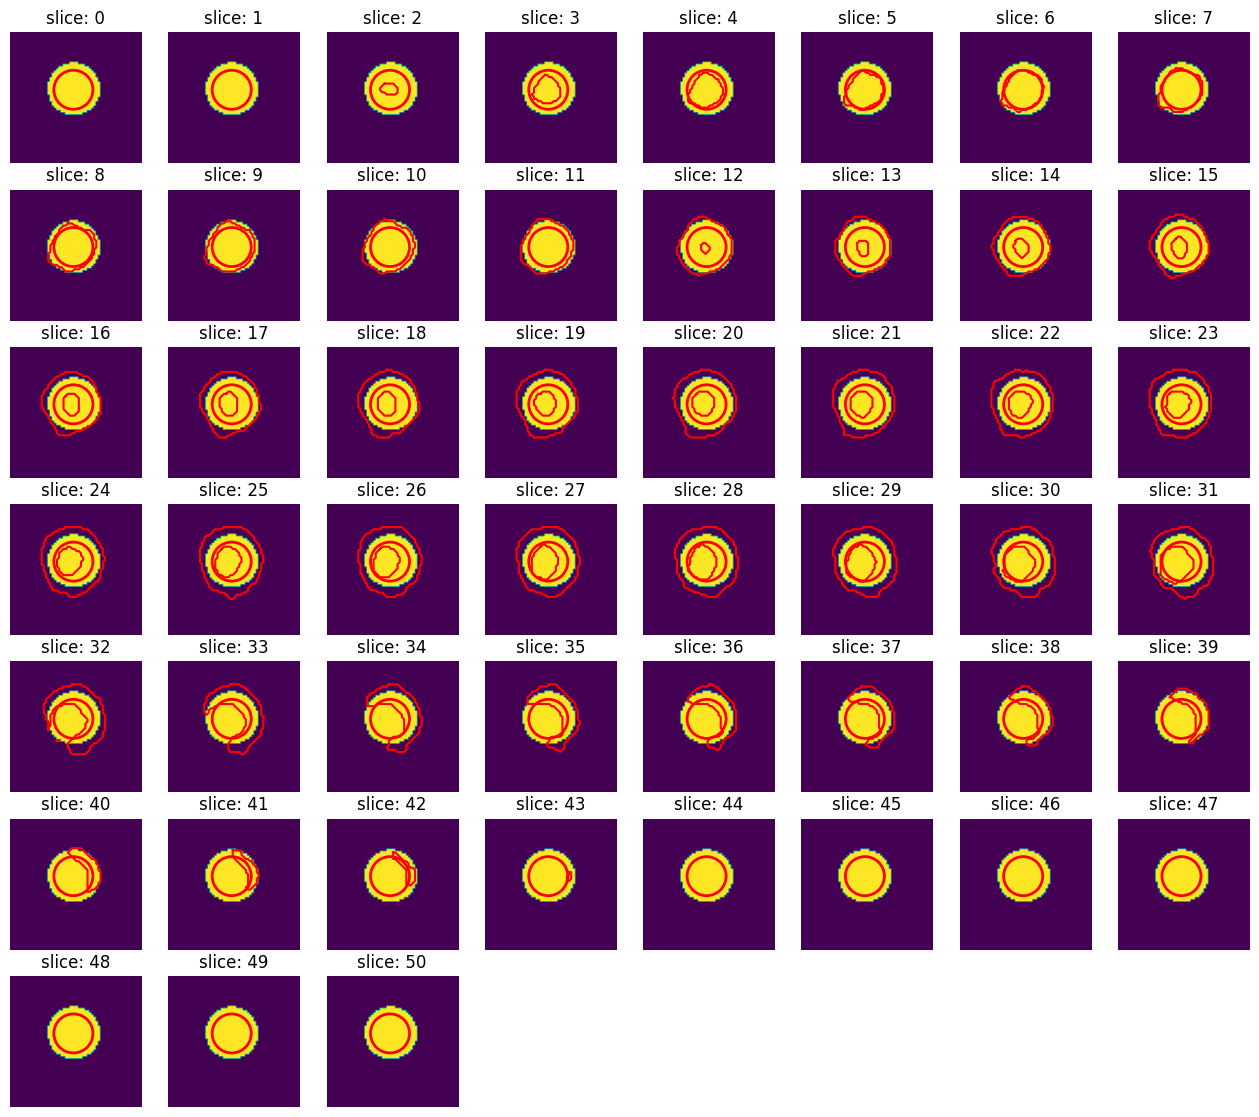

In [9]:
# step 3: generate mask3d
def generate_mask3d(img3d, param, thickness=3):
    # 根据传入的参数, 生成心脏mask
    # cylinder: circle_param 中只含有 center + radius
    # hybrid: 比 cylinder 多 apex_z, base_z
    # hybrid with plane: 比 hybrid 多 plane

    z_len, y_len, x_len = img3d.shape  # 使用 img3d 的形状
    # 使用 np.ogrid 生成三维坐标网格
    Z, Y, X = np.ogrid[:z_len, :y_len, :x_len]
    center = param["center"]
    radius = param["radius"]
    cy, cx = center["cy"], center["cx"]
    
    # 计算每个点与圆心在 XY 平面上的距离 (忽略 z 轴)
    distance_xy = np.sqrt((Y - cy) ** 2 + (X - cx) ** 2 + Z*0)
    cylinder_mask3d = (distance_xy <= radius+thickness).astype(np.uint8)
    # ret = cylinder_mask3d
    
    if param.get("apex_z", -1)==-1 and param.get("base_z", -1)==-1:
        return cylinder_mask3d
    
    # hybrid
    base_z = param["base_z"]
    dividing_z = param["dividing_z"]
    
    cylinder_mask3d = ((distance_xy <= radius+thickness) & (distance_xy >= radius-thickness) & (Z<=base_z) & (Z>=dividing_z)).astype(np.uint8)
    
    distance_semicircle = np.sqrt((Y - cy) ** 2 + (X - cx) ** 2 + ((Z-dividing_z)/2) ** 2)
    semicircle_mask3d = ((distance_semicircle <= radius+thickness) & (distance_semicircle >= radius-thickness) & (Z<=dividing_z)).astype(np.uint8)
    
    hybrid_mask3d = cylinder_mask3d | semicircle_mask3d
    
    
    if param.get("plane", -1)==-1:
        return hybrid_mask3d
    
    # hybrid with plane
    plane_param = param["plane"]
    a, b, c, d = plane_param["a"], plane_param["b"], plane_param["c"], plane_param["d"]
    
    plane_mask3d = (a*X + b*Y + c*Z + d >= 0).astype(np.uint8)
    hybrid_with_plane_mask3d = hybrid_mask3d & plane_mask3d
    
    # # 这里要删除收到斜切面影响的那部分
    # diff_mask3d = hybrid_mask3d - hybrid_with_plane_mask3d
    
    
    
    return hybrid_with_plane_mask3d


cylinder_mask3d = generate_mask3d(zoomed_clipped_non_gate_img3d, circle_param)

# 新机中线 和 每一层 比较
plt.figure(figsize=(16, 16))
for i in range(min(zoomed_clipped_non_gate_img3d.shape[0], 64)):
    ax = plt.subplot(8,8,i+1)
    plt.imshow(cylinder_mask3d[i])
    
    # 查找轮廓
    contours, _ = cv2.findContours(naive_lv_mask[i], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # 画轮廓
    for contour in contours:
        contour = contour.squeeze()  # 去掉冗余维度
        if len(contour.shape) == 2:  # 避免空轮廓
            contour = np.vstack([contour, contour[0]])
            ax.plot(contour[:, 0], contour[:, 1], color='r', linewidth=1.5)
    
    center = circle_param["center"]
    radius = circle_param["radius"]
    cy, cx = center["cy"], center["cx"]
    circle = Circle((cx,cy), radius, edgecolor='r', facecolor='none', linewidth=2)  # 'r' 是红色边缘，'none' 表示圆内透明
    ax.add_patch(circle)
    
    ax.set_title(f"slice: {i}")
    ax.set_axis_off()
plt.show()

In [10]:
# step 4: determine apex_z, base_z

def determine_apex_base(img3d, circle_param):
    # z 方向: 0->zlen, apex->base
    cylinder_mask = generate_mask3d(img3d, circle_param)
    img3d = img3d * cylinder_mask
    
    max_volume = img3d.max()
    
    z_len = img3d.shape[0]
    base_z, apex_z = z_len//2, z_len//2
    
    # The apex is considered to be the first slice apical to the center slice 
    # that does not contain a pixel greater than 40% of the maximum
    zs,_,_ = np.where(img3d>0.4*max_volume)
    
    # 防止为空
    meets_list = [val for val in range(0, z_len//2) if val not in np.unique(zs)] + [0]
    # print(f"np.unique(zs): {np.unique(zs)}, meets_list: {meets_list}")
    apex_z = max(max(meets_list), 0)
    
    zs,_,_ = np.where(img3d>0.65*max_volume)
    meets_list = [val for val in range(z_len//2, z_len) if val not in np.unique(zs)] + [z_len-1]
    base_z = min(min(meets_list), z_len-1)
    
    
    # 这里后面会用到!!! 实际发现,这样更好
    apex_len = 2*radius
    dividing_z = apex_z+apex_len
    return {"apex_z": apex_z, "base_z": base_z, "dividing_z": dividing_z}


loc_info = determine_apex_base(zoomed_clipped_non_gate_img3d, circle_param)

param = copy.deepcopy(circle_param)
param.update(loc_info)

print(f"old_info: {circle_param}")
print(f"new_info: {param}")

old_info: {'center': {'cy': 25.820621468926554, 'cx': 28.52683615819209}, 'radius': 8.938213117026617}
new_info: {'center': {'cy': 25.820621468926554, 'cx': 28.52683615819209}, 'radius': 8.938213117026617, 'apex_z': 0, 'base_z': 41, 'dividing_z': 17.876426234053234}


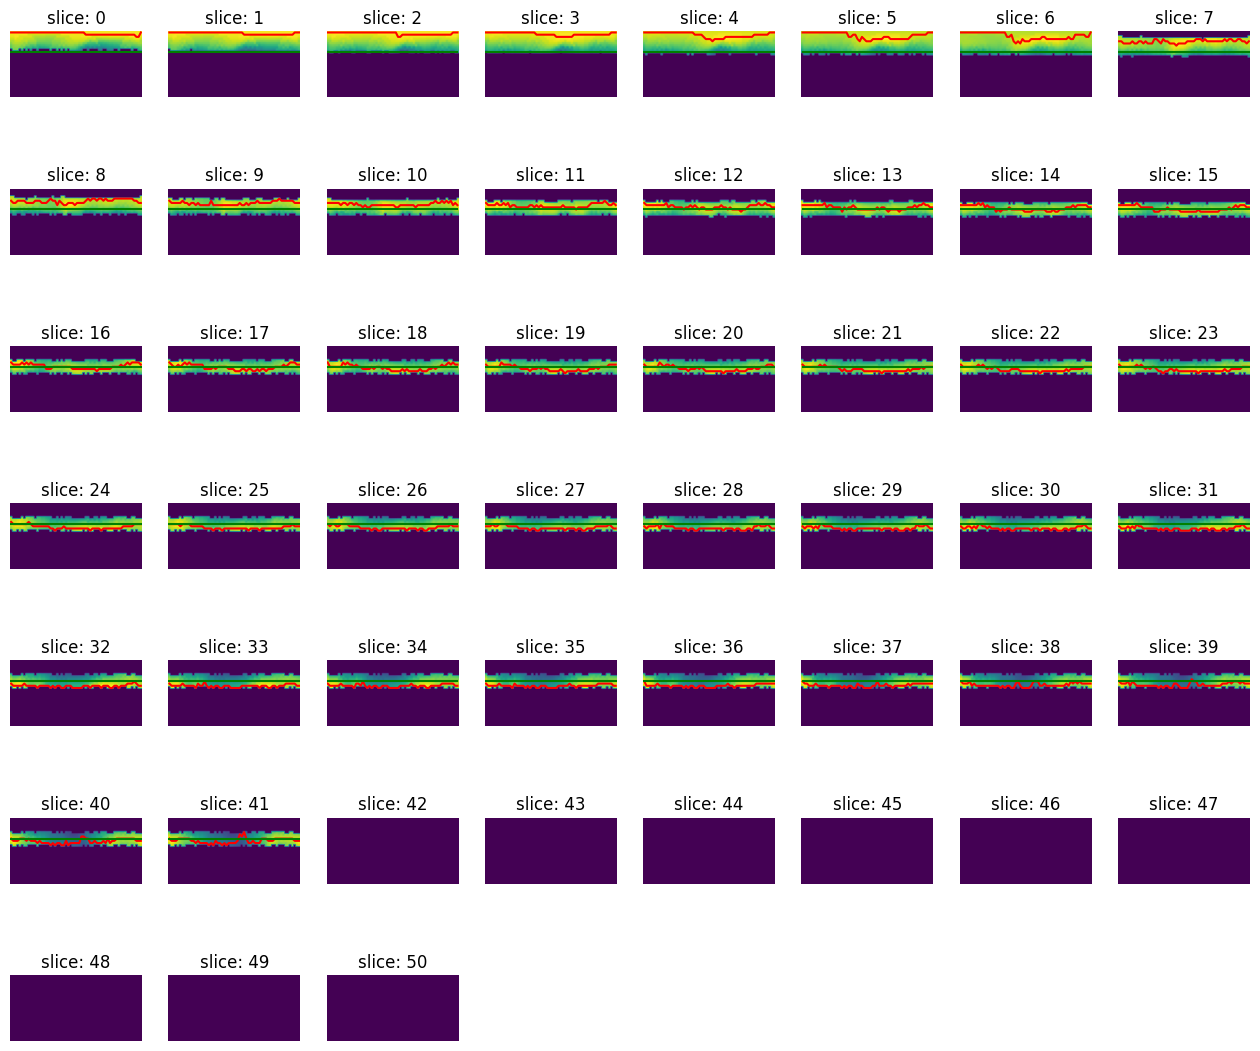

In [11]:
# step 5: polar unfold img3d by slice z
def polar_unfold_vector_optimized(img3d, param):
    """
    将图像从笛卡尔坐标系转换为极坐标系（优化版）。
    """
    z_len, y_len, x_len = img3d.shape
    
    # zs * rs * thetas
    out_z, out_y, out_x = (z_len, x_len//2, y_len)
    
    center = param["center"]
    cy, cx = center["cy"], center["cx"]
    
    # 创建空的极坐标图像
    polar_img3d = np.zeros((out_z, out_y, out_x), dtype=np.float32)

    # 计算所有的半径和角度值
    r_vals = np.linspace(0, out_y, out_y, endpoint=False)  # 半径值
    theta_vals = np.linspace(0, 2 * np.pi, out_x, endpoint=False)  # 角度值

    # 创建网格，计算每个点的 x 和 y 坐标
    r_grid, theta_grid = np.meshgrid(r_vals, theta_vals, indexing="ij")
    
    # 计算极坐标到笛卡尔坐标的转换
    x_vals = cx + r_grid * np.cos(theta_grid)  # x 坐标
    y_vals = cy + r_grid * np.sin(theta_grid)  # y 坐标
    
    # 限制坐标范围
    x_vals = np.round(np.clip(x_vals, 0, x_len - 1)).astype(int)
    y_vals = np.round(np.clip(y_vals, 0, y_len - 1)).astype(int)
    
    # 使用矩阵索引将笛卡尔坐标映射到极坐标图像
    polar_img3d = img3d[:, y_vals, x_vals]

    # return polar_img.transpose() # 如果需要与 OpenCV mat 轴一致的话
    return polar_img3d

# 平滑心肌中线
def weighted_smooth(data, weights, smoothness=0.1, max_diff=5):
        """
        加权最小二乘法平滑，并限制相邻数据点差值不超过 max_diff
        :param data: 原始数据（长度为64的数组）
        :param weights: 权重数组（长度为64）
        :param smoothness: 平滑系数（越大越平滑）
        :param max_diff: 相邻数据点最大允许差值
        :return: 平滑后的数据
        """
        n = len(data)
        
        def objective(x):
            # 目标函数：加权误差 + 平滑惩罚
            error = np.sum(weights * (x - data) ** 2)  # 加权误差
            smooth_penalty = np.sum((x[3:] - x[:-3]) ** 2)  # 平滑惩罚
            return error + smoothness * smooth_penalty
        
        def constraint(x):
            # 约束条件：相邻数据点差值不超过 max_diff
            return max_diff - np.abs(x[1:] - x[:-1])
        
        # 初始猜测为原始数据
        x0 = data.copy()
        
        # 约束条件
        cons = {'type': 'ineq', 'fun': constraint}  # 不等式约束
        
        # 最小化目标函数
        result = minimize(objective, x0, method='SLSQP', constraints=cons)
        # return result.x
        return np.round(result.x).astype(np.uint8)

# step 6: find best myocardium line
def find_max_val(polar_img3d, smoothness=None, max_diff=None):
    z_len, y_len, x_len = polar_img3d.shape
    lines = []
    
    for i in range(z_len):
        if np.sum(polar_img3d[i]) == 0:
            lines.append({})
            continue
        
        ys = np.argmax(polar_img3d[i], axis=0)
        xs = np.linspace(0, 2 * np.pi, x_len, endpoint=False)  # 角度值
        vals = np.max(polar_img3d[i], axis=0)
        
        res = {"ys": ys, "xs": xs, "vals": vals}
        
        if smoothness is not None:
            extend_ys = np.insert(ys, [0, x_len], [ys[[-1, 0]]]).astype(np.int8)
            extend_vals = np.insert(vals, [0, x_len], [vals[[-1, 0]]]).astype(np.float16)
            
            offset_ys = extend_ys[1:] - extend_ys[:-1]
            # print(i, offset_ys)
            if np.all(abs(offset_ys)<=3):
                res["smooth_ys"] = ys
            else:
                weights = extend_vals - np.min(extend_vals)
                
                # print("\t", extend_ys)
                # print("\t", weights)
                # print(f'ruuning on line {i}')
                smooth_vals = weighted_smooth(extend_ys, weights, 0.5, 5)
                # smooth_vals = weighted_smooth(extend_ys, weights, 0.5)
                
                # smooth_ys = weighted_smooth(slice_line["ys"], 
                #                             slice_line["vals"]-np.min(slice_line["vals"]), 
                #                             0.5, 5)
                res["smooth_ys"] = smooth_vals[1:-1]
                # print("\t", smooth_vals[1:-1])
        lines.append(res)
    
    return lines

hybrid_mask3d = generate_mask3d(zoomed_clipped_non_gate_img3d, param)
polar_img3d = polar_unfold_vector_optimized(zoomed_clipped_non_gate_img3d*hybrid_mask3d, param)
myocardium_info = find_max_val(polar_img3d)


plt.figure(figsize=(16, 16))

for i in range(min(zoomed_clipped_non_gate_img3d.shape[0], 64)):
    ax = plt.subplot(8,8,i+1)
    plt.imshow(polar_img3d[i])
    
    radius = param["radius"]
    slice_line = myocardium_info[i]
    
    if len(slice_line):
        plt.plot(range(len(slice_line["xs"])), slice_line["ys"], 'r')
        plt.plot(range(len(slice_line["xs"])), [radius]*len(slice_line["xs"]), 'g')
    
    ax.set_title(f"slice: {i}")
    ax.set_axis_off()
plt.show()

In [ ]:
# step 7: Recursively search for the param: center, radius, apex_z, base_z

# step 7.1: recalculate center, radius
def recalculate_center_radius(cur_param, myocardium_info):
    # TODO: 这里很多异常需要处理, base 边界
    # TODO: myocardium_info[i] 为空怎么办?
    cur_center = cur_param["center"]
    cur_radius = cur_param["radius"]
    cur_cy, cur_cx = cur_center["cy"], cur_center["cx"]
    
    cur_apex_z = cur_param["apex_z"]
    cur_base_z = cur_param["base_z"]
    cur_dividing_z = cur_param["dividing_z"]
    
    base3of4_start = int(cur_dividing_z)
    base_len = int(cur_base_z-base3of4_start)
    base3of4_end = int(cur_base_z - int(base_len*0.75))
    
    myocardium_radius = []
    myocardium_theta = []
    for i in range(base3of4_start, base3of4_end, 1):
        slice_line = myocardium_info[i]
        myocardium_radius.append(slice_line["ys"])
        myocardium_theta.append(slice_line["xs"])
        
    myocardium_radius = np.array(myocardium_radius)
    myocardium_theta = np.array(myocardium_theta)
    new_radius = np.median(myocardium_radius)
    
    # 去尾平均数
    myocardium_radius.sort(axis=0)
    xs = myocardium_radius[1:-1] * np.cos(myocardium_theta[1:-1]) + cx
    ys = myocardium_radius[1:-1] * np.sin(myocardium_theta[1:-1]) + cy
    new_cy, new_cx = np.mean(ys), np.mean(xs)
    
    new_circle_param = {
        "center": {
            "cy": new_cy,
            "cx": new_cx,
        },
        "radius": new_radius,
    }
    return new_circle_param


# step 7.2.1: 根据 param 和 myocardium_info 生成 myocardium_mask3d
def generate_myocardium_mask3d(img3d, param, myocardium_info):
    # 这里是old
    # cur_cardiac_center = (param["base"] + param["apex"])/2
    cur_center = param["center"]
    # cur_radius = param["radius"]
    cur_cy, cur_cx = cur_center["cy"], cur_center["cx"]
    
    polar_radius, polar_thetas, polar_zs, vals = [], [], [], []
    for zi, slice_myocardium_info in enumerate(myocardium_info):
        if len(slice_myocardium_info) == 0:
            continue
        polar_zs.extend(np.ones_like(slice_myocardium_info["ys"])*zi)
        polar_radius.extend(slice_myocardium_info["ys"])
        polar_thetas.extend(slice_myocardium_info["xs"])
        vals.extend(slice_myocardium_info["vals"])
        
    # polar coordinates -> decare coordinates
    decare_ys = np.array(polar_radius) * np.sin(np.array(polar_thetas)) + cur_cy
    decare_xs = np.array(polar_radius) * np.cos(np.array(polar_thetas)) + cur_cx
    
    decare_ys = np.round(decare_ys).astype(np.uint8)
    decare_xs = np.round(decare_xs).astype(np.uint8)
    decare_zs = np.array(polar_zs, np.uint8)
    
    # print(f"len: {len(decare_zs)}, vals: {decare_zs}, max: {decare_zs}")
    # print(f"len: {len(decare_ys)}, vals: {decare_ys}, max: {decare_ys}")
    # print(f"len: {len(decare_zs)}, vals: {decare_zs}, max: {decare_zs}")
    
    myocardium_mask3d = np.zeros_like(img3d)
    
    # print(f"img3d.shape: {img3d.shape}")
    myocardium_mask3d[decare_zs, decare_ys, decare_xs] = 1
    return myocardium_mask3d

# step 7.2: recalculate apex base 
def recalculate_apex_base(img3d, cur_param, next_param, myocardium_info):
    
    dividing_z = int(cur_param["dividing_z"])
    
    new_apex_z = 0
    for i in range(dividing_z, -1, -1):
        slice_line = myocardium_info[i]
        ys = slice_line["ys"]
        # 查找第一个 全是 0 而且 数量大于角度数量 的一半!
        if np.count_nonzero(ys == 0) >= 0.5*len(ys):
            new_apex_z = max(i-1, 0)
            break
    
    myocardium_mask3d = generate_myocardium_mask3d(img3d, cur_param, myocardium_info)
    myocardium_img3d = img3d*myocardium_mask3d
    # filt = myocardium_mask3d>0
    # print(np.max(myocardium_img3d[filt]), np.mean(myocardium_img3d[filt]), np.min(myocardium_img3d[filt]))
    # print(np.max(vals), np.mean(vals), np.min(vals))
    
    
    cur_cardiac_center = (cur_param["base_z"] + cur_param["apex_z"])/2
    
    # the sampled myocardia intensity fell to 30% of the maximum sampled counts.
    cylinder_mask3d = generate_mask3d(img3d, next_param)
    max_volume = np.max(img3d * cylinder_mask3d)
    zs, ys, xs = np.where((myocardium_img3d<=(0.3*max_volume)) & (myocardium_mask3d>0))
    z_map = np.ones_like(img3d[0], dtype=np.uint8)*255
    for z,y,x in zip(zs,ys,xs):
        if z < cur_cardiac_center:
            continue
        z_map[y, x] = min(z_map[y,x], z)
    new_base_z1 = np.mean(z_map[z_map<255])
    # print(f"new_base_z1: {new_base_z1}")
    
    # the first slice basal to the center slice in the short-axis volume that did not containa pixel greater than 65%
    zs, ys, xs = np.where(myocardium_img3d>=0.65*max_volume)
    meets_list = [val for val in np.unique(zs) if val > cur_cardiac_center] + [int(cur_cardiac_center)+1]
    new_base_z2 = np.max(meets_list)
    # print(f"new_base_z2: {new_base_z2}")
    
    # If the two baseestimates differed by lessthan 2.5 pixels, the former estimatewasused;
    # otherwise,a basal defect was assumed, and the latter estimate was assumed to be the more accurate one
    if abs(new_base_z1-new_base_z2) <= 3:
        new_base_z = new_base_z1
    else:
        new_base_z = new_base_z2
    
    return {"apex_z": new_apex_z, "base_z": new_base_z, "z_map": z_map}


def recalculate_param(img3d, cur_param, myocardium_info):
    
    next_param = recalculate_center_radius(cur_param, myocardium_info)
    next_loc_info = recalculate_apex_base(img3d, cur_param, next_param, myocardium_info)
    next_param.update(next_loc_info)
    
    # 这里后面会用到!!! 实际发现,这样更好
    apex_len = 2*next_param["radius"]
    apex_z = next_loc_info["apex_z"]
    dividing_z = apex_z+apex_len
    next_param["dividing_z"] = dividing_z
    return next_param


def recursive_find_best_param(img3d, cur_param, myocardium_info):
    while True:
        next_param = recalculate_param(img3d, cur_param, myocardium_info)

        cur_center = cur_param["center"]
        cur_radius = cur_param["radius"]
        cur_cy, cur_cx = cur_center["cy"], cur_center["cx"]
        cur_apex_z = cur_param["apex_z"]
        cur_base_z = cur_param["base_z"]
        
        
        next_center = next_param["center"]
        next_radius = next_param["radius"]
        next_cy, next_cx = next_center["cy"], next_center["cx"]
        next_apex_z = next_param["apex_z"]
        next_base_z = next_param["base_z"]
        
        print(abs(cur_cy-next_cy)<0.5 , abs(cur_cx-next_cx)<0.5 , abs(cur_apex_z-next_apex_z)<=1 , abs(cur_base_z-next_base_z)<=1)
        # scope = 1.5
        if abs(cur_cy-next_cy)<0.5 and abs(cur_cx-next_cx)<0.5 and abs(cur_apex_z-next_apex_z)<=1 and abs(cur_base_z-next_base_z)<=1:
            break
        else:
            cur_param = next_param
        
        print("loop")
        # print("loop")
        tmp = copy.deepcopy(next_param)
        tmp["z_map"] = None
        import json
        print(json.dumps(tmp, indent=4))
        # print(next_param)

    return next_param


final_param = recursive_find_best_param(zoomed_clipped_non_gate_img3d, param, myocardium_info)

print(f"final param: {final_param}")

True False True False
loop
{
    "center": {
        "cy": 25.486672564083104,
        "cx": 27.94498200367791
    },
    "radius": 10.0,
    "apex_z": 1,
    "base_z": 39.15151515151515,
    "z_map": null,
    "dividing_z": 21.0
}
True False True True
loop
{
    "center": {
        "cy": 25.214378673134924,
        "cx": 27.41640732303595
    },
    "radius": 10.0,
    "apex_z": 1,
    "base_z": 39.1875,
    "z_map": null,
    "dividing_z": 21.0
}
True False True True
loop
{
    "center": {
        "cy": 24.942084782186743,
        "cx": 26.887832642393995
    },
    "radius": 10.0,
    "apex_z": 1,
    "base_z": 39.111111111111114,
    "z_map": null,
    "dividing_z": 21.0
}
True False True True
loop
{
    "center": {
        "cy": 24.66979089123856,
        "cx": 26.359257961752032
    },
    "radius": 10.0,
    "apex_z": 1,
    "base_z": 39.111111111111114,
    "z_map": null,
    "dividing_z": 21.0
}
True False True True
loop
{
    "center": {
        "cy": 24.397497000290382,
    

TypeError: Object of type int64 is not JSON serializable

{'a': 0.3949827782806235, 'b': -0.07415200828626145, 'c': -1, 'd': 33.78220957859361}


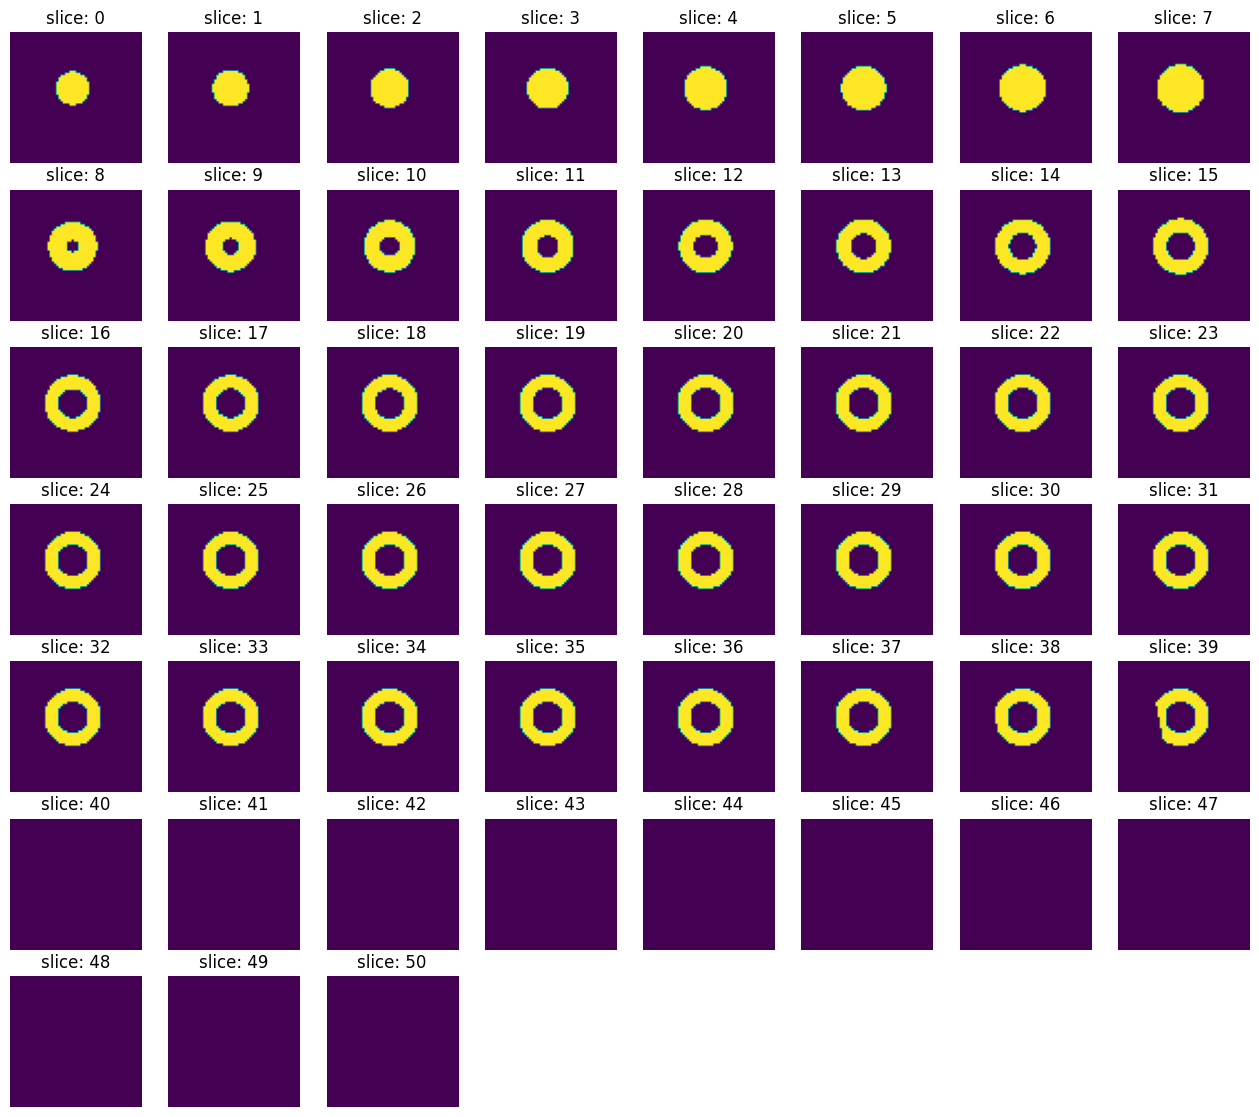

In [10]:
# step 8: 拟合 斜切面
def fit_angled_plane(z_map):
    """
    通过给定的三维点 (xs, ys, zs) 拟合一个平面。
    返回平面的系数 (a, b, c, d)，使得平面方程为: a*x + b*y + c*z + d = 0。
    """
    
    
    ys, xs = np.where(z_map < 255)
    zs = z_map[ys, xs]
    
    # 构造矩阵 A 和向量 b
    A = np.column_stack((xs, ys, np.ones_like(xs)))  # [x, y, 1]
    b = zs  # z 值

    # 使用最小二乘法求解平面方程的参数
    coefficients, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    # 提取平面方程的系数
    a, b, d = coefficients
    c = -1  # 平面方程形式为 a*x + b*y + c*z + d = 0，这里 c = -1
    
    
    return {
        "a": a,
        "b": b,
        "c": c,
        "d": d,
    }
    
plane_param = fit_angled_plane(final_param["z_map"])
print(plane_param)
final_param["plane"] = plane_param

hybrid_with_plane_mask3d = generate_mask3d(zoomed_clipped_non_gate_img3d, final_param)

# 新机中线 和 每一层 比较
plt.figure(figsize=(16, 16))
for i in range(min(zoomed_clipped_non_gate_img3d.shape[0], 64)):
    ax = plt.subplot(8,8,i+1)
    plt.imshow(hybrid_with_plane_mask3d[i], vmin=0, vmax=1)
    # plt.imshow(plane_mask3d[i], vmin=0, vmax=1, alpha=0.5 )
    
    ax.set_title(f"slice: {i}")
    ax.set_axis_off()
plt.show()

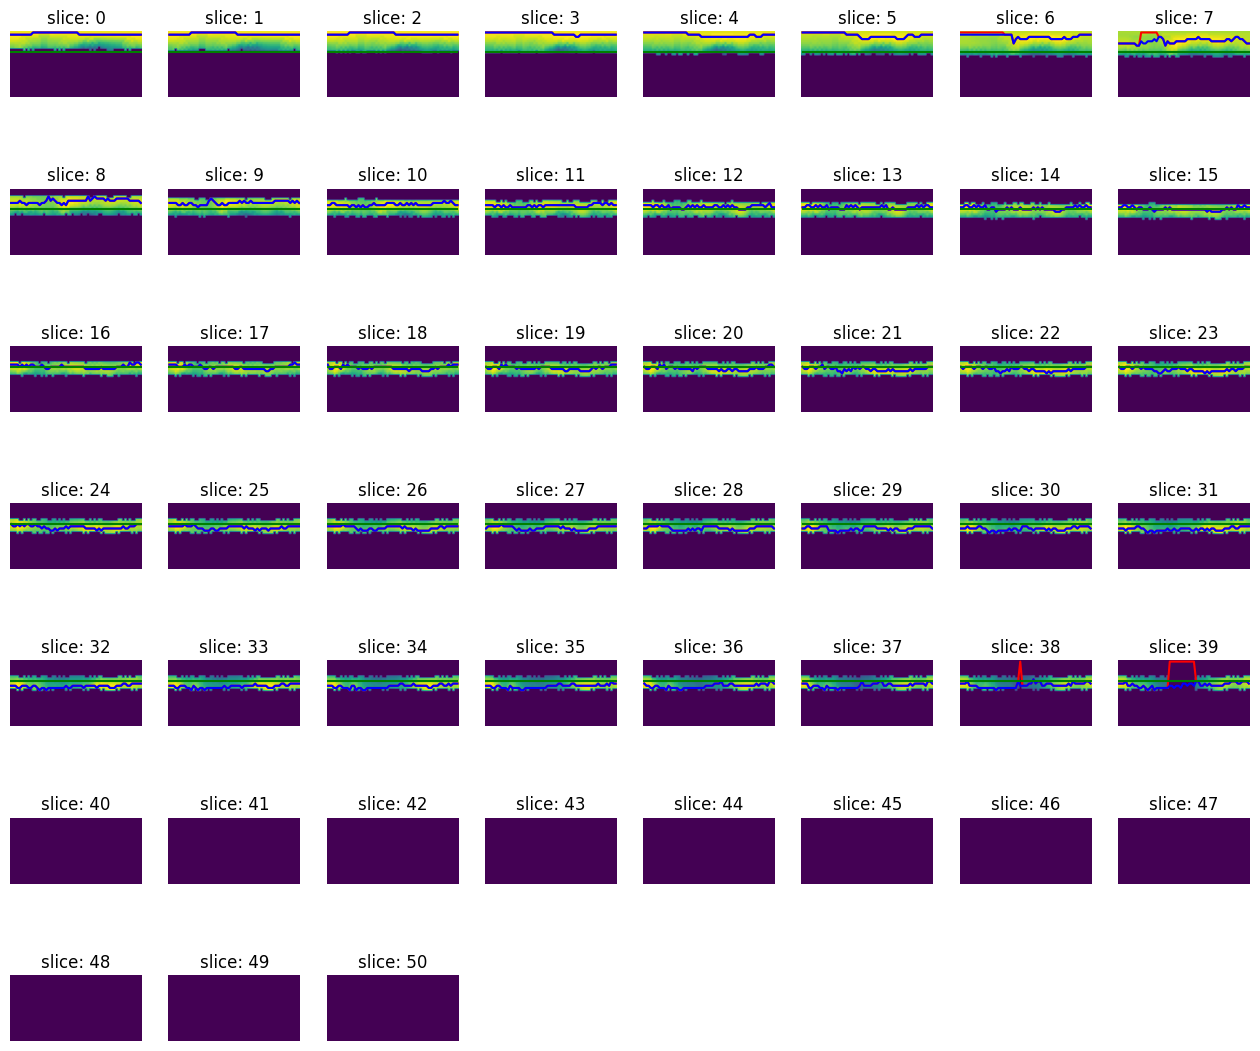

In [11]:
polar_mask3d = polar_unfold_vector_optimized(hybrid_with_plane_mask3d, final_param)
polar_img3d = polar_unfold_vector_optimized(zoomed_clipped_non_gate_img3d*hybrid_with_plane_mask3d, final_param)

def correct_polar_mask3d(polar_mask3d, param):
    # print(polar_mask3d.shape)
    dividing_z = int(param["dividing_z"])
    # print(dividing_z)
    absence_of_myocardium = {}
    std_mask2d = polar_mask3d[dividing_z]
    for z in range(dividing_z+1, polar_mask3d.shape[0]):
        diff = polar_mask3d[z] - std_mask2d
        
        # 没区别
        if np.sum(diff) == 0:
            continue
        
        ys, xs = np.where(diff == 255)
        # print(xs, np.unique(diff))
        
        absence_of_myocardium[z] = np.unique(xs)
        polar_mask3d[z, :, np.unique(xs)] = 0
        
        # 心脏区域结束了, 靠近 base 那边
        if np.sum(diff) > 0.8*np.sum(std_mask2d):
            break
    
    param["angled_plane"] = absence_of_myocardium
    return polar_mask3d

corrected_polar_mask3d = correct_polar_mask3d(polar_mask3d, final_param)
corrected_polar_img3d = polar_img3d * corrected_polar_mask3d

myocardium_info = find_max_val(polar_img3d*corrected_polar_mask3d, 0.5, 5)


plt.figure(figsize=(16, 16))

for i in range(min(zoomed_clipped_non_gate_img3d.shape[0], 64)):
    ax = plt.subplot(8,8,i+1)
    plt.imshow(corrected_polar_img3d[i])
    
    radius = param["radius"]
    slice_line = myocardium_info[i]
    
    
    
    
    if len(slice_line):
        # plt.plot(range(len(slice_line["xs"])), slice_line["ys"], 'r')
        
        plt.plot(range(len(slice_line["xs"])), slice_line["ys"], 'r')
        plt.plot(range(len(slice_line["xs"])), slice_line["smooth_ys"], 'b')
        
        # print(i)
        # print(slice_line["ys"])
        # print(slice_line["smooth_ys"])
        
        plt.plot(range(len(slice_line["xs"])), [radius]*len(slice_line["xs"]), 'g')
    
    ax.set_title(f"slice: {i}")
    ax.set_axis_off() 
plt.show()

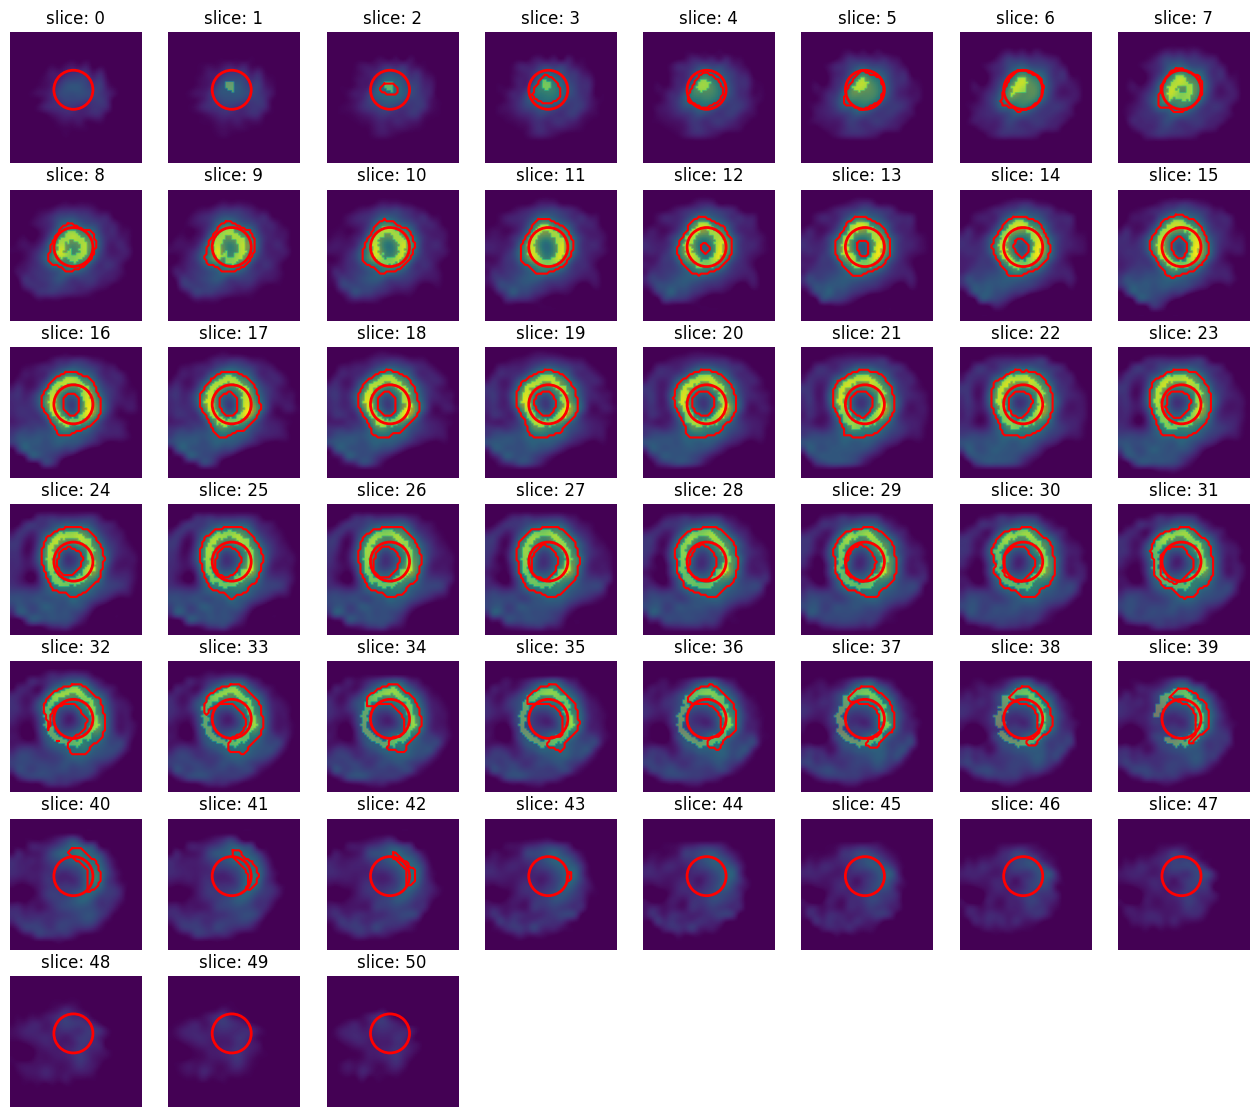

In [32]:
# step 10: 生成mask3d

def polar_fold_vector_optimized(polar_img3d, myocardium_info, param, width=7):
    """
    将极坐标图像重新映射回笛卡尔坐标系（优化版）。
    :param polar_img3d: 极坐标图像，形状为 (z_len, r_len, theta_len)
    :param param: 包含中心点信息的参数字典
    :return: 笛卡尔坐标系下的图像，形状为 (z_len, y_len, x_len)
    """
    z_len, r_len, theta_len = polar_img3d.shape
    
    # 获取原始笛卡尔图像的尺寸
    center = param["center"]
    cy, cx = center["cy"], center["cx"]
    
    base_z = param["base_z"]
    apex_z = param["apex_z"]
    
    
    # 假设原始图像的尺寸为 (z_len, y_len, x_len)
    # 这里假设 y_len 和 x_len 是极坐标图像的半径和角度的最大值
    y_len = int(2 * r_len)  # 假设原始图像的 y 方向尺寸是极坐标半径的两倍
    x_len = int(2 * r_len)  # 假设原始图像的 x 方向尺寸是极坐标半径的两倍
    
    # 创建空的笛卡尔图像
    cartesian_img3d = np.zeros((z_len, y_len, x_len), dtype=np.uint8)
    
    
    for z in range(cartesian_img3d.shape[0]):
        if z<apex_z or z>base_z:
            continue
        # print(z, myocardium_info[z])
        ys, xs = myocardium_info[z]["smooth_ys"].astype(np.int8), myocardium_info[z]["xs"]
        
        
        r_width = width/2  # 环的宽度
        
        # 计算内外边界
        r_inner = ys - r_width // 2
        r_outer = ys + r_width // 2
        
        
        # 转换为笛卡尔坐标
        x_inner = (r_inner * np.cos(xs) + cx).astype(np.int32)
        y_inner = (r_inner * np.sin(xs) + cy).astype(np.int32)

        x_outer = (r_outer * np.cos(xs) + cx).astype(np.int32)
        y_outer = (r_outer * np.sin(xs) + cy).astype(np.int32)
        
        # for z, xs in param["angled_plane"].items():
        #     # absence_of_myocardium[z] = np.unique(xs)
        #     polar_mask3d[z, :, xs] = 0
            # param["angled_plane"] = absence_of_myocardium
            # 画出填充的环
        
        
        
        pts = np.vstack((np.column_stack((x_outer, y_outer)), np.column_stack((x_inner[::-1], y_inner[::-1]))))
        cv2.fillPoly(cartesian_img3d[z], [pts], 255)
    
    # 生成网格坐标
    Y, X = np.meshgrid(np.arange(y_len), np.arange(x_len), indexing='ij')
    
    # 计算每个像素点相对于中心点的 θ
    theta_map = np.arctan2(Y - cy, X - cx)  # 结果单位：弧度 [-π, π]
    
    # 根据 theta_map 删除缺口平面点
    for tmp_z, uqi_xs in param["angled_plane"].items():
        # absence_of_myocardium[z] = np.unique(xs)
        # if tmp_z == z:
        #     r_inner[ uqi_xs] = 20
        #     r_outer[ uqi_xs] = 10
        
        min_th, max_th = np.min(uqi_xs)-0.5, np.max(uqi_xs)+0.5
        # min_th = 
        min_th, max_th = min_th*2*np.pi/64, max_th*2*np.pi/64
        cartesian_img3d[tmp_z][(theta_map>= min_th) & (theta_map<= max_th)] = 0
        
        # print(tmp_z, min_th, max_th)
        # plt.imshow(theta_map)
        # plt.show()
        
        
    
    return cartesian_img3d


final_polar_mask3d = polar_fold_vector_optimized(polar_mask3d, myocardium_info, final_param, 5)





# 新机中线 和 每一层 比较
plt.figure(figsize=(16, 16))
for i in range(min(zoomed_clipped_non_gate_img3d.shape[0], 64)):
    ax = plt.subplot(8,8,i+1)
    plt.imshow(zoomed_clipped_non_gate_img3d[i], vmin=0, vmax=np.max(zoomed_clipped_non_gate_img3d))
    
    
    # 查找轮廓
    contours, _ = cv2.findContours(naive_lv_mask[i], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # 画轮廓
    for contour in contours:
        contour = contour.squeeze()  # 去掉冗余维度
        if len(contour.shape) == 2:  # 避免空轮廓
            contour = np.vstack([contour, contour[0]])
            ax.plot(contour[:, 0], contour[:, 1], color='r', linewidth=1.5)
    
    center = circle_param["center"]
    radius = circle_param["radius"]
    cy, cx = center["cy"], center["cx"]
    circle = Circle((cx,cy), radius, edgecolor='r', facecolor='none', linewidth=2)  # 'r' 是红色边缘，'none' 表示圆内透明
    ax.add_patch(circle)
    
    
    plt.imshow(final_polar_mask3d[i], alpha=0.3)
    
    ax.set_title(f"slice: {i}")
    ax.set_axis_off()
plt.show()